Name : Kshitij Ranjan

Roll : 19AR10016

Indian Institute of Technology Kharagpur

Dashtoon_Generative_AI_Assignment

#Task Description
The goal of this assignment is to develop a deep learning model that can mimic the style of any artwork by modifying an already-existing piece. The model should be able to examine the chosen works of art and use similar stylistic elements to produce a fresh, original piece that has the appearance of having been created by the artist.



## 1 - Imports and necessary libraries

In [1]:
import IPython.display as display
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import time
import functools

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

Mounting my personal Google Drive since Dataset is stored there

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/MyDrive/dashtoon_data

/content/drive/MyDrive/dashtoon_data


In [4]:
import glob
content = glob.glob('content_train/**/*.jpg',  recursive = True)
print("Number of content '.jpg' files : ", len(content))

style = glob.glob('style_train/**/*.jpg',  recursive = True)
print("Number of style '.jpg' files : ", len(style))


Number of content '.jpg' files :  404
Number of style '.jpg' files :  648


In [5]:
# Function for converting a tensor to an image
def tensor_to_image(tensor):
    # Scale the tensor values to the range [0, 255]
    tensor = tensor * 255

    # Convert the tensor to a NumPy array with integer values
    tensor = np.array(tensor, dtype=np.uint8)

    # If the tensor has more than 3 dimensions (e.g., batch dimension), handle it
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]  # Remove the dummy dimension in the tensor

    # Create an image object from the NumPy array using PIL library
    return PIL.Image.fromarray(tensor)

In [8]:
# Defining a function to load an image and set its maximum shape to 512 pixels
def load_img(path_to_img):
    # Set the maximum shape for the image
    max_shape = 512

    # Read the contents of the image file
    image = tf.io.read_file(path_to_img)

    # Decode the image data and convert it to a TensorFlow tensor with 3 channels (RGB)
    image = tf.image.decode_image(image, channels=3)

    # Convert the image tensor to float32 format
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Get the shape of the image and cast it to float32
    shape = tf.cast(tf.shape(image)[:-1], tf.float32)

    # Find the longest dimension of the image
    longest_dim = max(shape)

    # Calculate the scale factor to normalize every dimension with the maximum dimension
    scale = max_shape / longest_dim

    # Calculate the new shape by scaling the original shape
    new_shape = tf.cast(shape * scale, tf.int32)

    # Resize the image to the new shape
    image = tf.image.resize(image, new_shape)

    # Add a dummy axis to the image
    image = image[tf.newaxis, :]

    return image

In [9]:
# Function used for plotting images using Matplotlib
def imshow(image, title=None):
    # If the image has more than 3 dimensions (e.g., batch dimension), squeeze the first dimension
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)  # Remove the first dimension (batch dimension)

    # Use Matplotlib's imshow function to display the image
    plt.imshow(image)

    # Set the title of the plot if provided
    if title:
        plt.title(title)


Example path:  content_train/horse-1.jpg


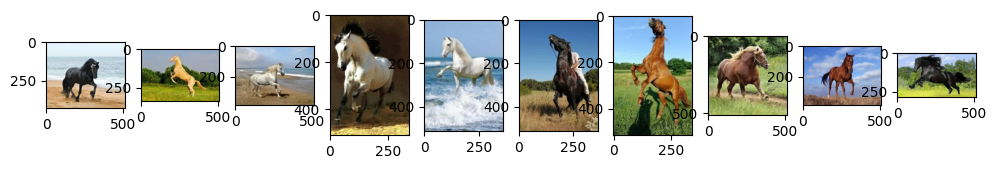

In [13]:
# Example paths for content and style images
content_path = content[0]
style_path = style[5]
print("Example path: ", content_path)

# Visualizing original content images
content_image = load_img(content_path)  # Load the content image using the load_img function
style_image = load_img(style_path)      # Load the style image using the load_img function

# Displaying the first 10 content images
for i in range(10):
    plt.subplot(1, 10, i + 1)  # Create subplots in a single row
    imshow(load_img(content[i]))  # Load and display each content image using the imshow function

plt.show()  # Show the plot


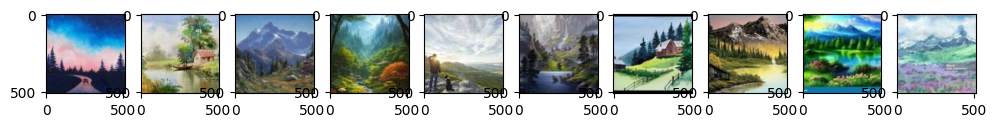

In [14]:
# Visualizing Style Images
for i in range(10):
  plt.subplot(1,10,i+1)
  imshow(load_img(style[i]))


### Loading VGG Model in Keras

In [15]:
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
print(vgg.summary())

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
# Create a VGG19 model with pre-trained weights from ImageNet, excluding the dense layers
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# Print the names of each layer in the VGG19 model
for layer in vgg.layers:
    print(layer.name)

# Define the content layers for feature extraction (subject to experimentation)
content_layers = ['block5_conv2']

# Define the style layers for feature extraction (subject to experimentation)
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

# Get the number of content and style layers
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


### Defining model using the functional API

Specify the inputs and outputs:
`model = Model(inputs, outputs)`

In [17]:
# Creates a VGG model that returns a list of intermediate output values.
def vgg_layers(layer_names):
    # Create a VGG19 model with pre-trained weights from ImageNet, excluding the dense layers
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

    # Set the VGG model to non-trainable
    vgg.trainable = False

    # Get the intermediate outputs corresponding to the specified layer names
    outputs = [vgg.get_layer(name).output for name in layer_names]

    # Create a new model using the Functional API of Keras with the specified layer outputs
    model = tf.keras.Model([vgg.input], outputs)

    return model


block1_conv1
  shape:  (1, 512, 512, 64)

block2_conv1
  shape:  (1, 256, 256, 128)

block3_conv1
  shape:  (1, 128, 128, 256)

block4_conv1
  shape:  (1, 64, 64, 512)

block5_conv1
  shape:  (1, 32, 32, 512)



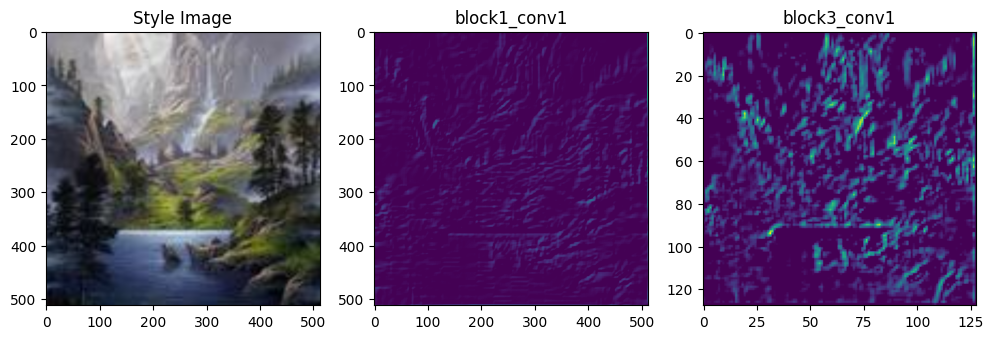

In [18]:
# Create the model for style image using the specified style layers
new_model = vgg_layers(style_layers)

# Get the style outputs for the style image
style_outputs = new_model(style_image * 255)  # Scale the style image values to [0, 255]

# Visualize the style image and its intermediate style layers
plt.subplot(1, 3, 1)
imshow(style_image, 'Style Image')
plt.subplot(1, 3, 2)
imshow(tf.convert_to_tensor(style_outputs[0])[0, :, :, 0], 'block1_conv1')
plt.subplot(1, 3, 3)
imshow(tf.convert_to_tensor(style_outputs[2])[0, :, :, 0], 'block3_conv1')

# Print information about each layer in the new model
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print()


In [19]:
def gram_matrix(input_tensor):
    # Compute the Gram matrix using the einsum (einsum stands for Einstein summation)
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)

    # Get the shape of the input tensor
    input_shape = tf.shape(input_tensor)

    # Calculate the number of locations (pixels) in the input tensor
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)

    # Normalize the Gram matrix by dividing it by the number of locations
    return result / num_locations


In [20]:
# Function for defining Total Cost
# Note: The content loss equations may be slightly changed from what is mentioned in the arxiv paper.
# This does not appreciably affect performance.

# Clear the Keras session to avoid potential issues with layer names
tf.keras.backend.clear_session()

def style_content_loss(outputs, content_targets, style_targets, content_weight, style_weight):
    # Extract style and content outputs from the model's intermediate layers
    style_output = outputs['style']
    content_output = outputs['content']

    # Style loss calculation
    style_loss = 0.25 * tf.add_n([tf.reduce_mean((style_output[name] - style_targets[name]) ** 2)
                                   for name in style_output.keys()])
    style_loss *= style_weight / num_style_layers

    # Content loss calculation
    content_loss = 0.25 * tf.add_n([tf.reduce_mean((content_output[name] - content_targets[name]) ** 2)
                                     for name in content_output.keys()])
    content_loss *= content_weight / num_content_layers

    # Total loss, combining style and content losses with specified weights
    total_loss = style_weight * style_loss + content_weight * content_loss

    return total_loss


### Extract style and content

When called on an image, this model returns the gram matrix (style) of the
style_layers and content of the content_layers:

In [21]:
# Class for combining Style and Content for the Image in a single Dictionary
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        # Create a VGG model with both style and content layers
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False  # Set the VGG model to non-trainable

    def call(self, inputs):
        # Expects float input in the range [0, 1]
        inputs = inputs * 255.0  # Scale the inputs to the range [0, 255]

        # Preprocess the input image using VGG19 preprocessing
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)

        # Get the outputs from the VGG model
        outputs = self.vgg(preprocessed_input)

        # Split the outputs into style and content representations
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        # Convert style outputs to Gram matrices
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        # Create dictionaries for content and style representations
        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        # Return a dictionary containing both content and style representations
        return {'content': content_dict, 'style': style_dict}


In [22]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

# Setting style and content target values:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

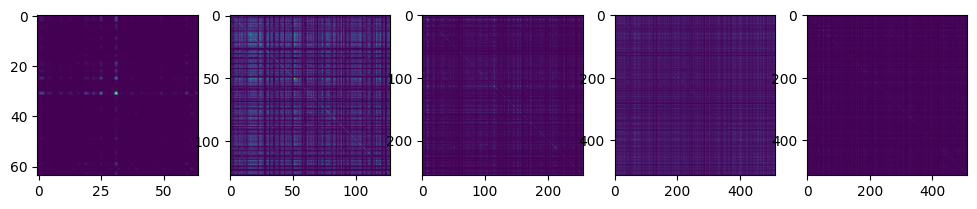

In [19]:
#For visualizing Gram Matrix diagonal elements
for i in range(len(style_layers)):
  plt.subplot(1,5,i+1)
  imshow(results['style'][style_layers[i]][0,:,:])

## **6 - Training using Gradient Descent**

In [23]:
# Function to clip pixel values between 0 and 1
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# Defining an optimizer (Adam optimizer with specific parameters)
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# Style and content target values obtained from the extractor
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']


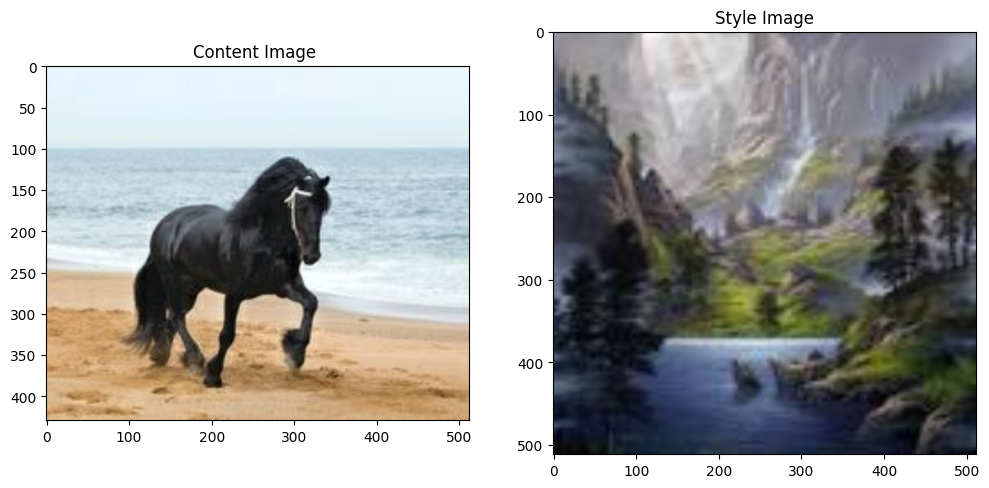

In [24]:
# Initialize a tf.Variable for the image to be optimized
image = tf.Variable(content_image)

# Display the content and style images using Matplotlib subplots
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image ')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

# Function for a single training step
def train_step(image, content_targets, style_targets, content_weight, style_weight):
    # Use a GradientTape to compute the gradients of the loss with respect to the image
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs, content_targets, style_targets, content_weight, style_weight)

    # Compute the gradient of the loss with respect to the image
    grad = tape.gradient(loss, image)

    # Apply the gradients using the optimizer
    opt.apply_gradients([(grad, image)])

    # Clip the pixel values of the image to be within the range [0, 1]
    image.assign(clip_0_1(image))

    return loss


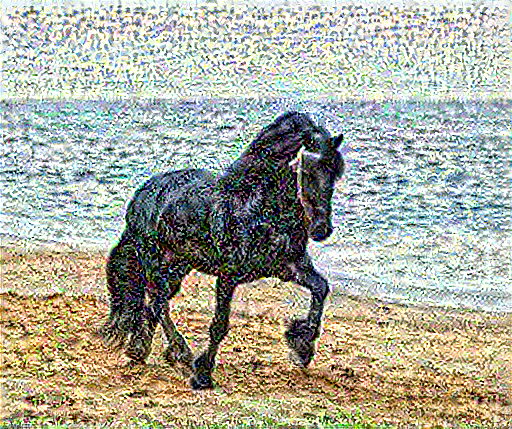

Train steps completed: 200
Loss -  123640775000.0


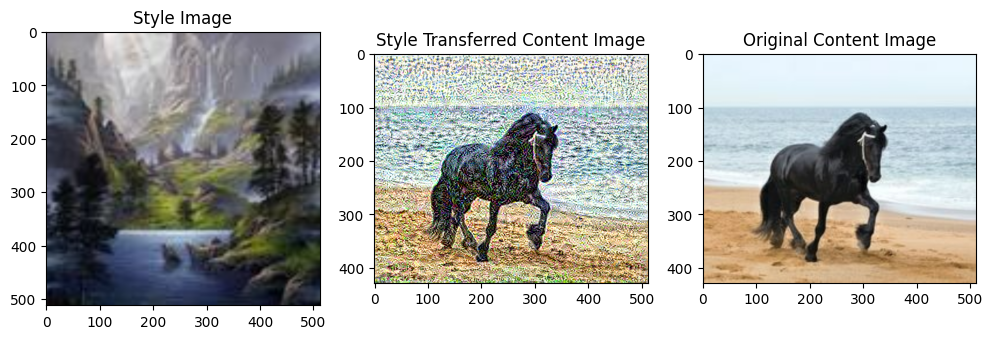

In [25]:
# Training parameters
epochs = 10
steps_per_epoch = 20  # How many steps the model trains in one epoch

style_weight = 1  # Weight of style image
content_weight = 1e5  # Weight of content image

step = 0

# Training loop
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        loss = train_step(image, content_targets, style_targets, content_weight, style_weight)
        print("*", end='', flush=True)

    # Clear the output for a cleaner display
    display.clear_output(wait=True)

    # Display the current stylized image
    display.display(tensor_to_image(image))

    # Print information about the training progress
    print("Train steps completed: {}".format(step))
    print("Loss - ", loss.numpy(), flush=False)

# Display the original style image, content image, and the final stylized image
plt.subplot(1, 3, 1)
imshow(style_image, "Style Image")
plt.subplot(1, 3, 3)
imshow(content_image, "Original Content Image")
plt.subplot(1, 3, 2)
imshow(image, "Style Transferred Content Image")


## **7 - Evaluating Effectiveness of model**

In [26]:
def evaluate(content_file, style_file, c_weight, s_weight):
  c_path = content[content_file]
  s_path = style[style_file]

  # Code for loading content and style image
  c_image = load_img(c_path)
  image2 = tf.Variable(c_image)
  s_image = load_img(s_path)

  # Code for content_target tensor according to new style image
  results = extractor(c_image)
  # Setting style and content target values:
  s_targets = extractor(s_image)['style']
  c_targets = extractor(c_image)['content']

  epochs = 10
  steps_per_epoch = 50    # How many steps the model trains in one epoch

  step = 0
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
      loss = train_step(image2, c_targets, s_targets, c_weight, s_weight)
      print("*", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image2))
    print("Train steps completed: {}".format(step))
    print("Loss - ", loss.numpy(), flush = False)

  plt.subplot(1,3,1)
  imshow(s_image, "Style Image")
  plt.subplot(1,3,3)
  imshow(c_image, "Original content Image")
  plt.subplot(1,3,2)
  imshow(image2,"Style transferred Content Image")

  #content_loss = 0.25*tf.add_n([tf.reduce_mean((c_image-image2)**2)])
  #style_loss = 0.25*tf.add_n([tf.reduce_mean((s_image-s_targets)**2)])
  #print("The content Loss for this Image is: ", content_loss)
  #print("The style Loss for this Image is: ", style_loss)

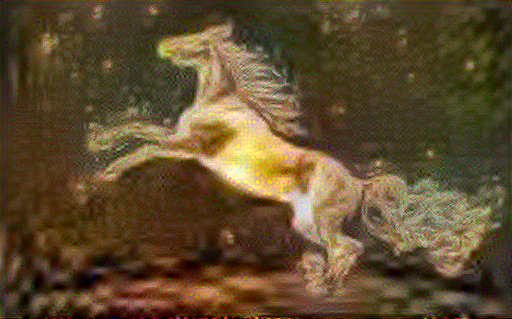

Train steps completed: 500
Loss -  733904500000.0


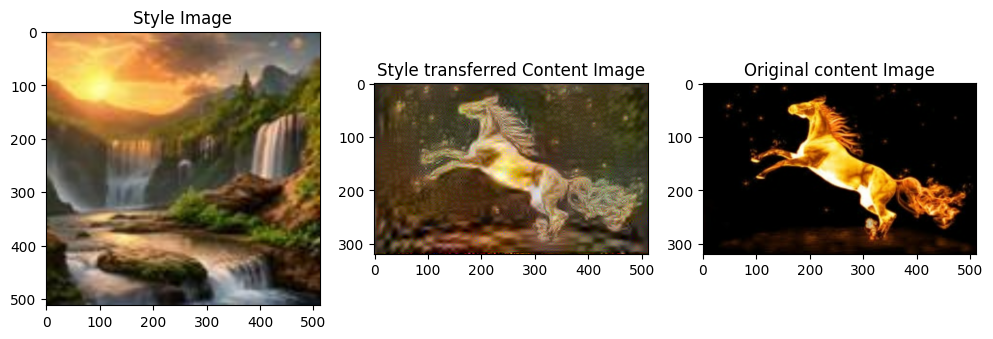

In [27]:
#Example 1
evaluate(150, -30, c_weight = 1e5, s_weight = 100)

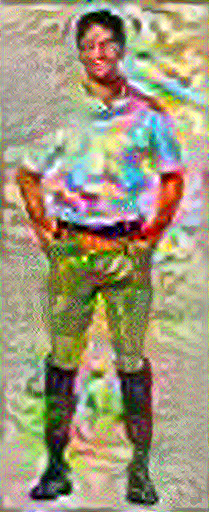

Train steps completed: 500
Loss -  127866420.0


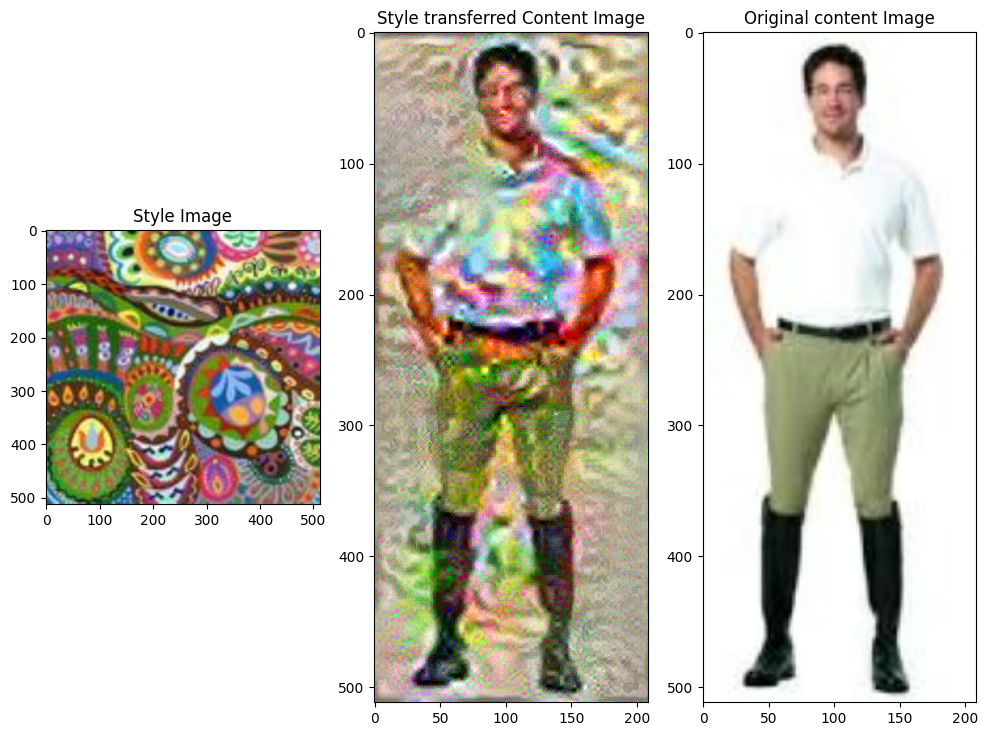

In [28]:
#example2
evaluate(-100, -500, 1000, 1)

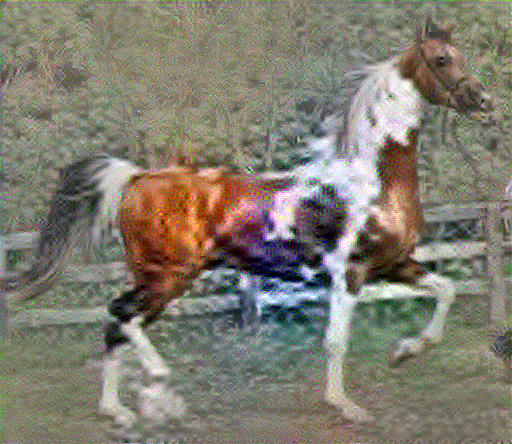

Train steps completed: 500
Loss -  56447944.0


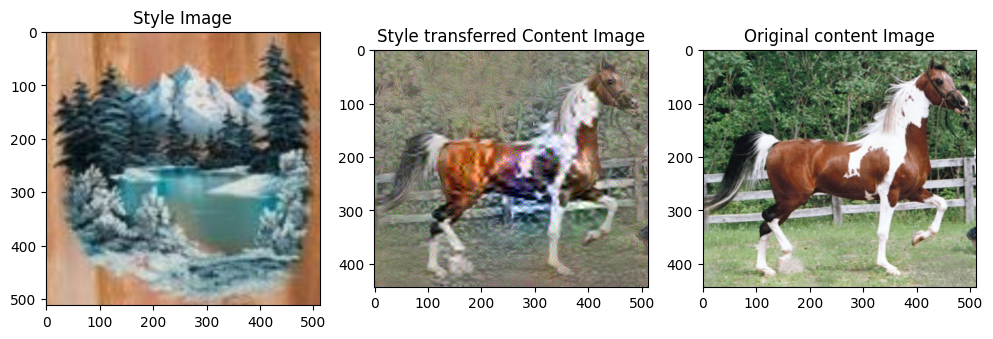

In [29]:
#example3
evaluate(-200, -300, 1e3, 1)

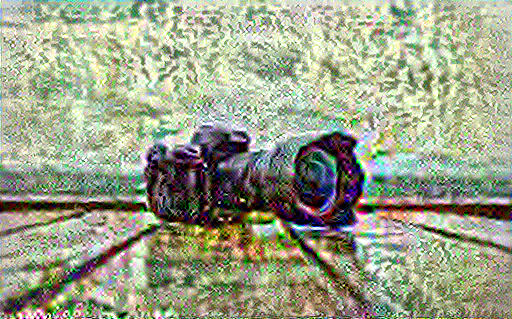

Train steps completed: 200
Loss -  28098848.0


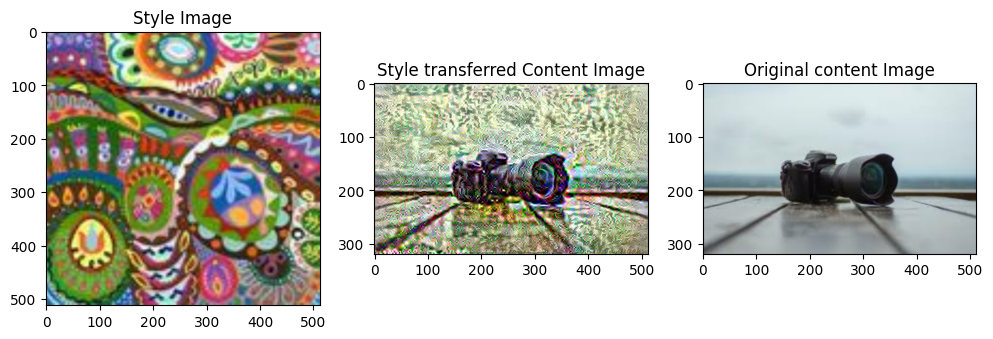

In [30]:
def evaluate(style_file, c_weight, s_weight):
  c_path = "/content/download.jpg"
  s_path = style[style_file]

  # Code for loading content and style image
  c_image = load_img(c_path)
  image2 = tf.Variable(c_image)
  s_image = load_img(s_path)

  # Code for content_target tensor according to new style image
  results = extractor(c_image)
  # Setting style and content target values:
  s_targets = extractor(s_image)['style']
  c_targets = extractor(c_image)['content']

  epochs = 10
  steps_per_epoch = 20    # How many steps the model trains in one epoch

  step = 0
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
      loss = train_step(image2, c_targets, s_targets, c_weight, s_weight)
      print("*", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image2))
    print("Train steps completed: {}".format(step))
    print("Loss - ", loss.numpy(), flush = False)

  plt.subplot(1,3,1)
  imshow(s_image, "Style Image")
  plt.subplot(1,3,3)
  imshow(c_image, "Original content Image")
  plt.subplot(1,3,2)
  imshow(image2,"Style transferred Content Image")

#example5
evaluate(-500, 1e3, 0.1)

## **8 - Conclusion**
Neural Style Transfer has made it possible for us to produce creative visuals.

An algorithm called Neural Style Transfer can create an artistic image from a content image (C) and a style image (S).
It makes use of pretrained ConvNet-based representations, or hidden layer activations.
The activations of one hidden layer are used to calculate the content cost function.
The Gramme matrix representing the activations of a layer is used to calculate the style cost function for that layer. Several hidden layers are used to derive the overall style cost function.
Constructing new images is the outcome of optimising the total cost function.


# **Limitations of my Model**
1. High Computational Cost:
Performing Neural Style Transfer on high-resolution images is computationally intensive, making it time-consuming and resource-demanding, particularly without GPU acceleration.

2. Logical Inconsistency:
The generated images may lack logical coherence, leading to instances where the model applies the style of one object (e.g., a cat) to another object (e.g., a dog), resulting in visually confusing outputs.

3. Challenges in Style Control:
Controlling where the style is applied on the content image is challenging, as it depends on the choice of CNN layers. This lack of precise style control can lead to unexpected results.

4. Resolution Limitations:
NST struggles to produce high-quality images because the CNN layers used are often not designed for very high-resolution images. Consequently, fine details in the content image may not be faithfully captured.

# **Potential improvements of my Model**
1. Enhance Interpretability and Control in Style Transfer:
Improve the interpretability of the NST model to provide better control over the style transfer process, allowing users to understand and manipulate the outcome more effectively.

2. Enhance Code Readability:
Address issues of code readability in the notebook. Streamline and organize the code to make it more comprehensible for readers, ensuring clarity and ease of understanding.

3. Optimize Performance:
Optimize the performance of the style transfer, especially in scenarios without GPU resources. This can involve additional preprocessing steps for both content and style images to reduce their size while preserving essential content through techniques like image compression.

4. Explore Generative Adversarial Networks (GANs):
Consider incorporating Generative Adversarial Networks (GANs) into the NST model. While this might introduce computational challenges, exploring GANs could potentially enhance the quality and diversity of generated stylized images.

5. Refine the Loss Function:
Improve the loss function used in the model to address instances of over-styling observed in some images. This refinement can help achieve a better balance between content and style, mitigating issues of excessive styling even with higher weights assigned to the content image.

#THANK YOU!!